# Polynomial Fitting

Similarly to the linear fit and the transit model we can instead fit our data with a polynomial model. The difference from the linear fit tutorial is that in this case we'll generate a slightly different polynomial function  for each wavelength and see how well our model can recover the parameters.

In [ ]:
from chromatic_fitting import *

planet = TransitModel()
planet.setup_parameters(period = 3.4, 
                        epoch = Fitted(Normal, mu=0.0, sigma=0.01),
                        radius_ratio = WavelikeFitted(...),
                        ...)

bkg = PolynomialModel(degree=2, indep_variable="background")
bkg.setup_parameters(p_0 = ..., p_2 = ...)

ramp = ExponentialModel()
ramp.setup_parameters(A = ..., decay_time = ...)

total = planet * (bkg + ramp)
total.attach_data(*Rainbow*); total.setup_likelihood(); total.sample()
total.plot_transmission_spectrum()

In [1]:
from chromatic_fitting import *

# distributions we might want to use:
from pymc3 import Normal, Uniform

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.9.3!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.4.5
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


First we'll create a Rainbow object from chromatic and then add a wavelength-dependent polynomial model:

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

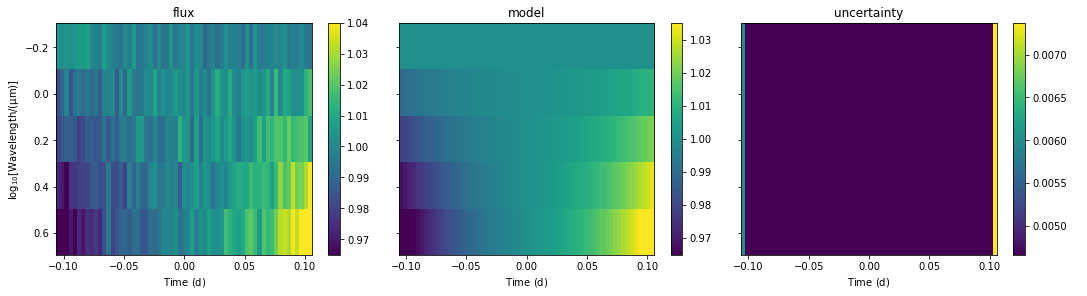

In [4]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=20)

# bin:
nw = 5
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# create wavelength-dep cubic + constant model:
a = 0.0
b = 0.05
c = 0.0
d = 5.0
x = rb.time.to_value("day")

true_a, true_b, true_c, true_d, poly = [],[],[],[],[]

for i in range(rb.nwave):
    true_a.append(a + 1)
    true_b.append(b*i)
    true_c.append(c*i)
    true_d.append(d*i)
    poly.append((d*i*(x**3)) + (c*i*(x**2)) + (b*i*x))
rb.fluxlike['flux'] = rb.flux + np.array(poly)
rb.fluxlike['model'] = 1 + np.array(poly)

# plot our Rainbow to see how it looks
rb.imshow_quantities();

Let's plot our data in 2-D so we can see the polynomial shapes we've added:

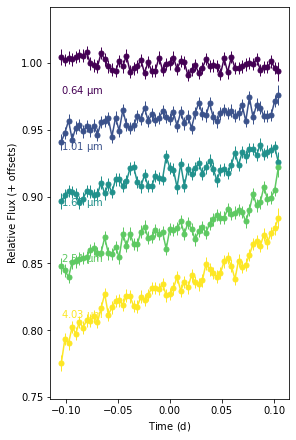

In [5]:
rb.plot_lightcurves();

## Create Polynomial Model

We set up the `PolynomialModel` similarly to the [linear model tutorial](https://catrionamurray.github.io/chromatic_fitting/tutorial_for_linear_fitting/), however, we need to provide the `degree` of the polynomial. By setting this argument we can fix some of our degrees to zero. For example if we have a linear model but we want a zero constant offset we could ignore the `p_0` parameter which would be fixed by default to 0. 

In [9]:
# set up polynomial model:
p = PolynomialModel(degree=3)

p.setup_parameters(
    p_0 = WavelikeFitted(Uniform,testval=0.01,upper=2,lower=-2),
    p_1 = WavelikeFitted(Uniform,testval=0.02,upper=1,lower=-1),
    p_2 = WavelikeFitted(Uniform,testval=0.03,upper=1,lower=-1),
    p_3 = WavelikeFitted(Uniform,testval=0.04,upper=25,lower=-5)
)

# print a summary of all params:
p.summarize_parameters()

polynomial_p_0 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>

polynomial_p_3 =
  <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>



In [10]:
p.parameters

{'polynomial_p_0': <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>,
 'polynomial_p_1': <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>,
 'polynomial_p_2': <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>,
 'polynomial_p_3': <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>}

In [16]:
# setup model the same way as for the transit model!:
p.attach_data(rb)

# If we don't want to fit everything simultaneously we can change the optimization method (the options 
# are "separate" or "white_light"). This has to be set BEFORE running .setup_lightcurves!
# p.choose_optimization_method("separate")

p.setup_lightcurves(store_models=True, normalize=False)

p.setup_likelihood()

In [15]:
p.optimization

'simultaneous'

Let's check our PyMC3 model and make sure that the parameters have been set up okay!

In [17]:
print(p._pymc3_model)

polynomial_p_0_interval__ ~ TransformedDistribution
polynomial_p_1_interval__ ~ TransformedDistribution
polynomial_p_2_interval__ ~ TransformedDistribution
polynomial_p_3_interval__ ~ TransformedDistribution
           polynomial_p_0 ~ Uniform
           polynomial_p_1 ~ Uniform
           polynomial_p_2 ~ Uniform
           polynomial_p_3 ~ Uniform
         polynomial_model ~ Deterministic
                     data ~ Normal


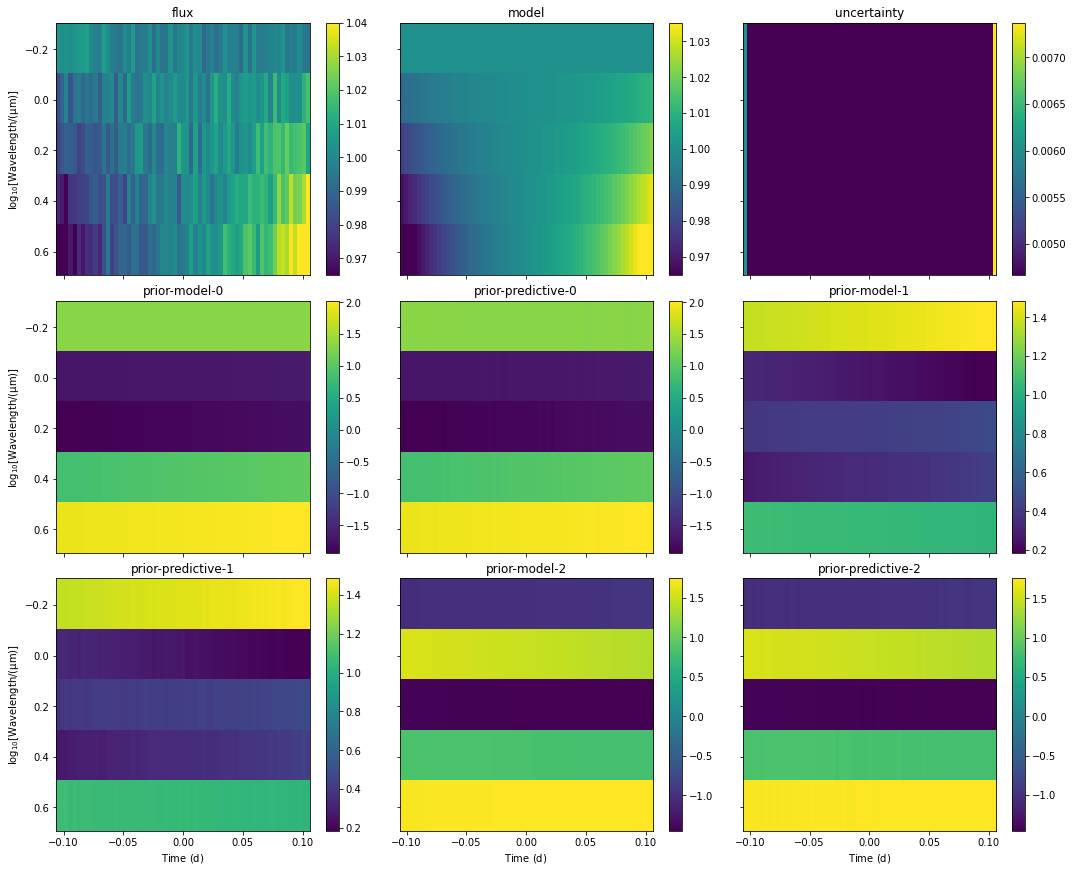

In [18]:
p.plot_priors(n=3)

Looks good, now onto sampling our model...

## Sampling our Model

Now we can try to fit our model! Here we will first perform an optimization step (to give our sampling a good first guess) and then the actual NUTS sampling with a number of tuning and draw steps and chains that we define. We can also choose how many cores to assign to this sampling! Bear in mind that we have a decent number of parameters to fit (simultaneously) and so we want to make sure we have enough steps in the MCMC!

optimizing logp for variables: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -6758305.963311314 -> 1174.9190906622714
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


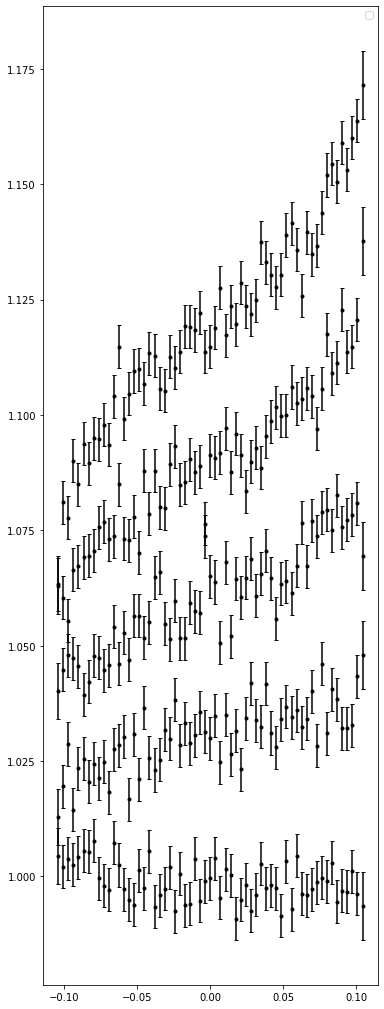

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 56 seconds.


In [19]:
# optimize for initial values!
opt = p.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(start=opt, tune=2000, draws=4000, chains=4, cores=4, return_inferencedata=False)

Now we can look at our results:

In [21]:
p.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

Summarize has already been run
                             mean        sd   hdi_16%   hdi_84%  mcse_mean  \
polynomial_p_0[0]        0.997409  0.000922  0.996456  0.998290   0.000009   
polynomial_p_0[1]        1.001370  0.000899  1.000514  1.002277   0.000008   
polynomial_p_0[2]        1.000047  0.000900  0.999212  1.000980   0.000008   
polynomial_p_0[3]        0.998647  0.000914  0.997702  0.999535   0.000008   
polynomial_p_0[4]        0.999434  0.000897  0.998506  1.000290   0.000008   
...                           ...       ...       ...       ...        ...   
polynomial_model[4, 56]  1.034513  0.001433  1.033072  1.035929   0.000013   
polynomial_model[4, 57]  1.037196  0.001573  1.035614  1.038752   0.000014   
polynomial_model[4, 58]  1.040028  0.001735  1.038284  1.041745   0.000016   
polynomial_model[4, 59]  1.043014  0.001919  1.041077  1.044905   0.000018   
polynomial_model[4, 60]  1.046160  0.002126  1.044117  1.048352   0.000021   

                          mcse_s

In [25]:
p.summary[~p.summary.index.str.contains(f"{p.name}_model")]

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
polynomial_p_0[0],0.997409,0.000922,0.996456,0.998290,0.000009,0.000006,10908.797736,9471.940768,1.000324
polynomial_p_0[1],1.001370,0.000899,1.000514,1.002277,0.000008,0.000006,12841.475233,10178.545123,1.000157
polynomial_p_0[2],1.000047,0.000900,0.999212,1.000980,0.000008,0.000006,12805.105857,10098.425139,1.000626
polynomial_p_0[3],0.998647,0.000914,0.997702,0.999535,0.000008,0.000005,13893.835507,10146.188565,1.000446
polynomial_p_0[4],0.999434,0.000897,0.998506,1.000290,0.000008,0.000005,13661.630073,9937.073202,1.000296
polynomial_p_1[0],-0.015250,0.018811,-0.030501,0.005874,0.000236,0.000210,7185.088569,4790.557243,1.000047
polynomial_p_1[1],0.061402,0.024351,0.036901,0.085865,0.000265,0.000202,8288.007294,6921.621059,1.000394
polynomial_p_1[2],0.127504,0.024582,0.103093,0.151891,0.000245,0.000185,10146.245015,6271.150650,1.000003
polynomial_p_1[3],0.145623,0.024372,0.118115,0.167276,0.000274,0.000194,7713.866335,4891.733292,1.000650
polynomial_p_1[4],0.200483,0.018977,0.177044,0.213782,0.000227,0.000164,7718.671235,5742.730107,1.000088


r_hat parameters are close to 1, which is a good sign that our chains have converged!

In [27]:
np.all(p.summary['r_hat']<1.01)

True

In [28]:
p.get_results(uncertainty=['hdi_16%','hdi_84%'])

,polynomial_p_0,polynomial_p_0_hdi_16%,polynomial_p_0_hdi_84%,polynomial_p_1,polynomial_p_1_hdi_16%,polynomial_p_1_hdi_84%,polynomial_p_2,polynomial_p_2_hdi_16%,polynomial_p_2_hdi_84%,polynomial_p_3,polynomial_p_3_hdi_16%,polynomial_p_3_hdi_84%,wavelength
w0,0.997409,0.996456,0.99829,-0.01525,-0.030501,0.005874,0.39035,0.195382,0.574711,-1.435853,-4.983648,-0.514461,0.639572482934883 micron
w1,1.00137,1.000514,1.002277,0.061402,0.036901,0.085865,-0.260727,-0.437972,-0.071699,3.226987,-0.430198,6.48712,1.013209338074884 micron
w2,1.000047,0.999212,1.00098,0.127504,0.103093,0.151891,0.1259,-0.052527,0.315336,6.261776,2.861447,9.744984,1.604998553797903 micron
w3,0.998647,0.997702,0.999535,0.145623,0.118115,0.167276,0.269948,0.086806,0.460574,15.60011,12.194514,19.102044,2.542436455025025 micron
w4,0.999434,0.998506,1.00029,0.200483,0.177044,0.213782,0.144662,-0.042303,0.322996,21.475241,20.401226,24.787335,4.027407446906737 micron


In [29]:
model = p.get_model()
model.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4'])

## Plot Results

Remember that handy `plot_lightcurves()` function from earlier? Once we have generated a model it *should* now overplot those models on top of the data.

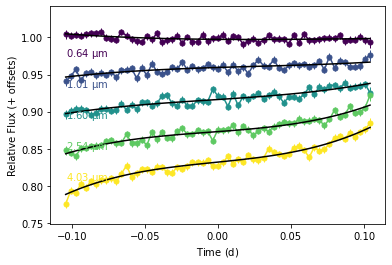

In [31]:
p.plot_lightcurves()

We can also use the `chromatic` functions wrapped in `chromatic_fitting` that can let us look at the residuals:

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


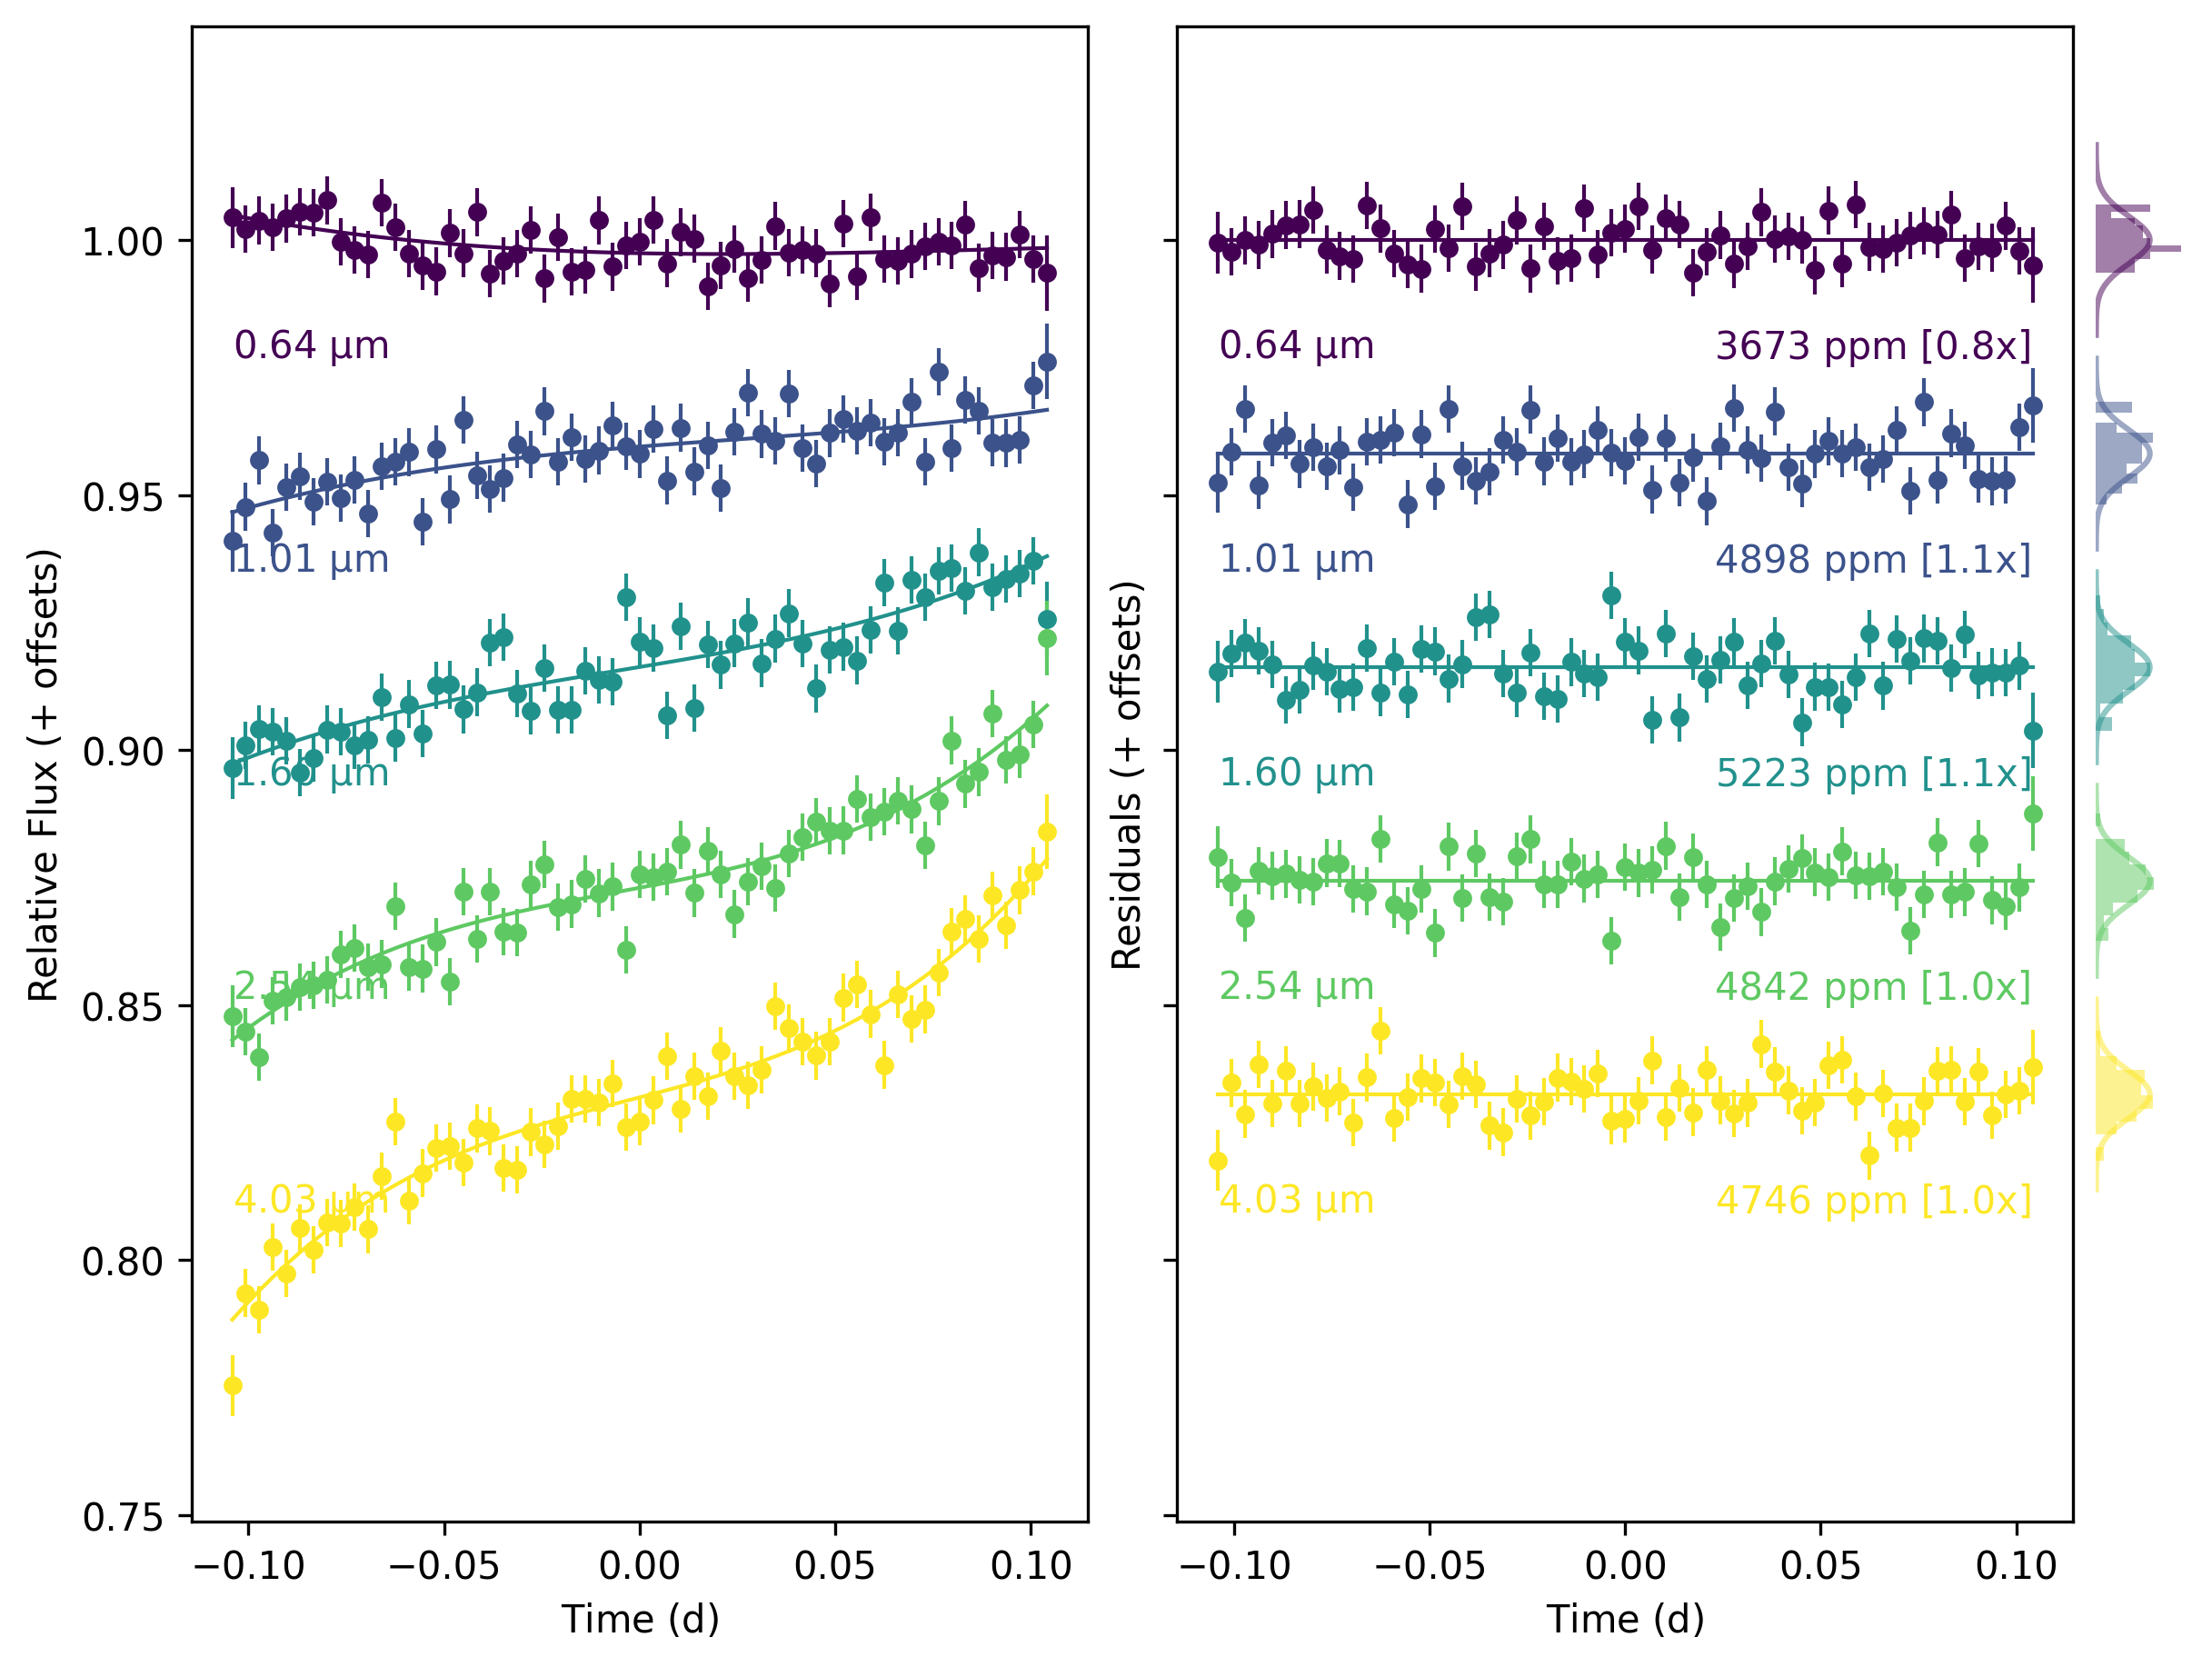

In [32]:
p.plot_with_model_and_residuals()

🌈🤖 'planet_model' doesn't exist and will be skipped.



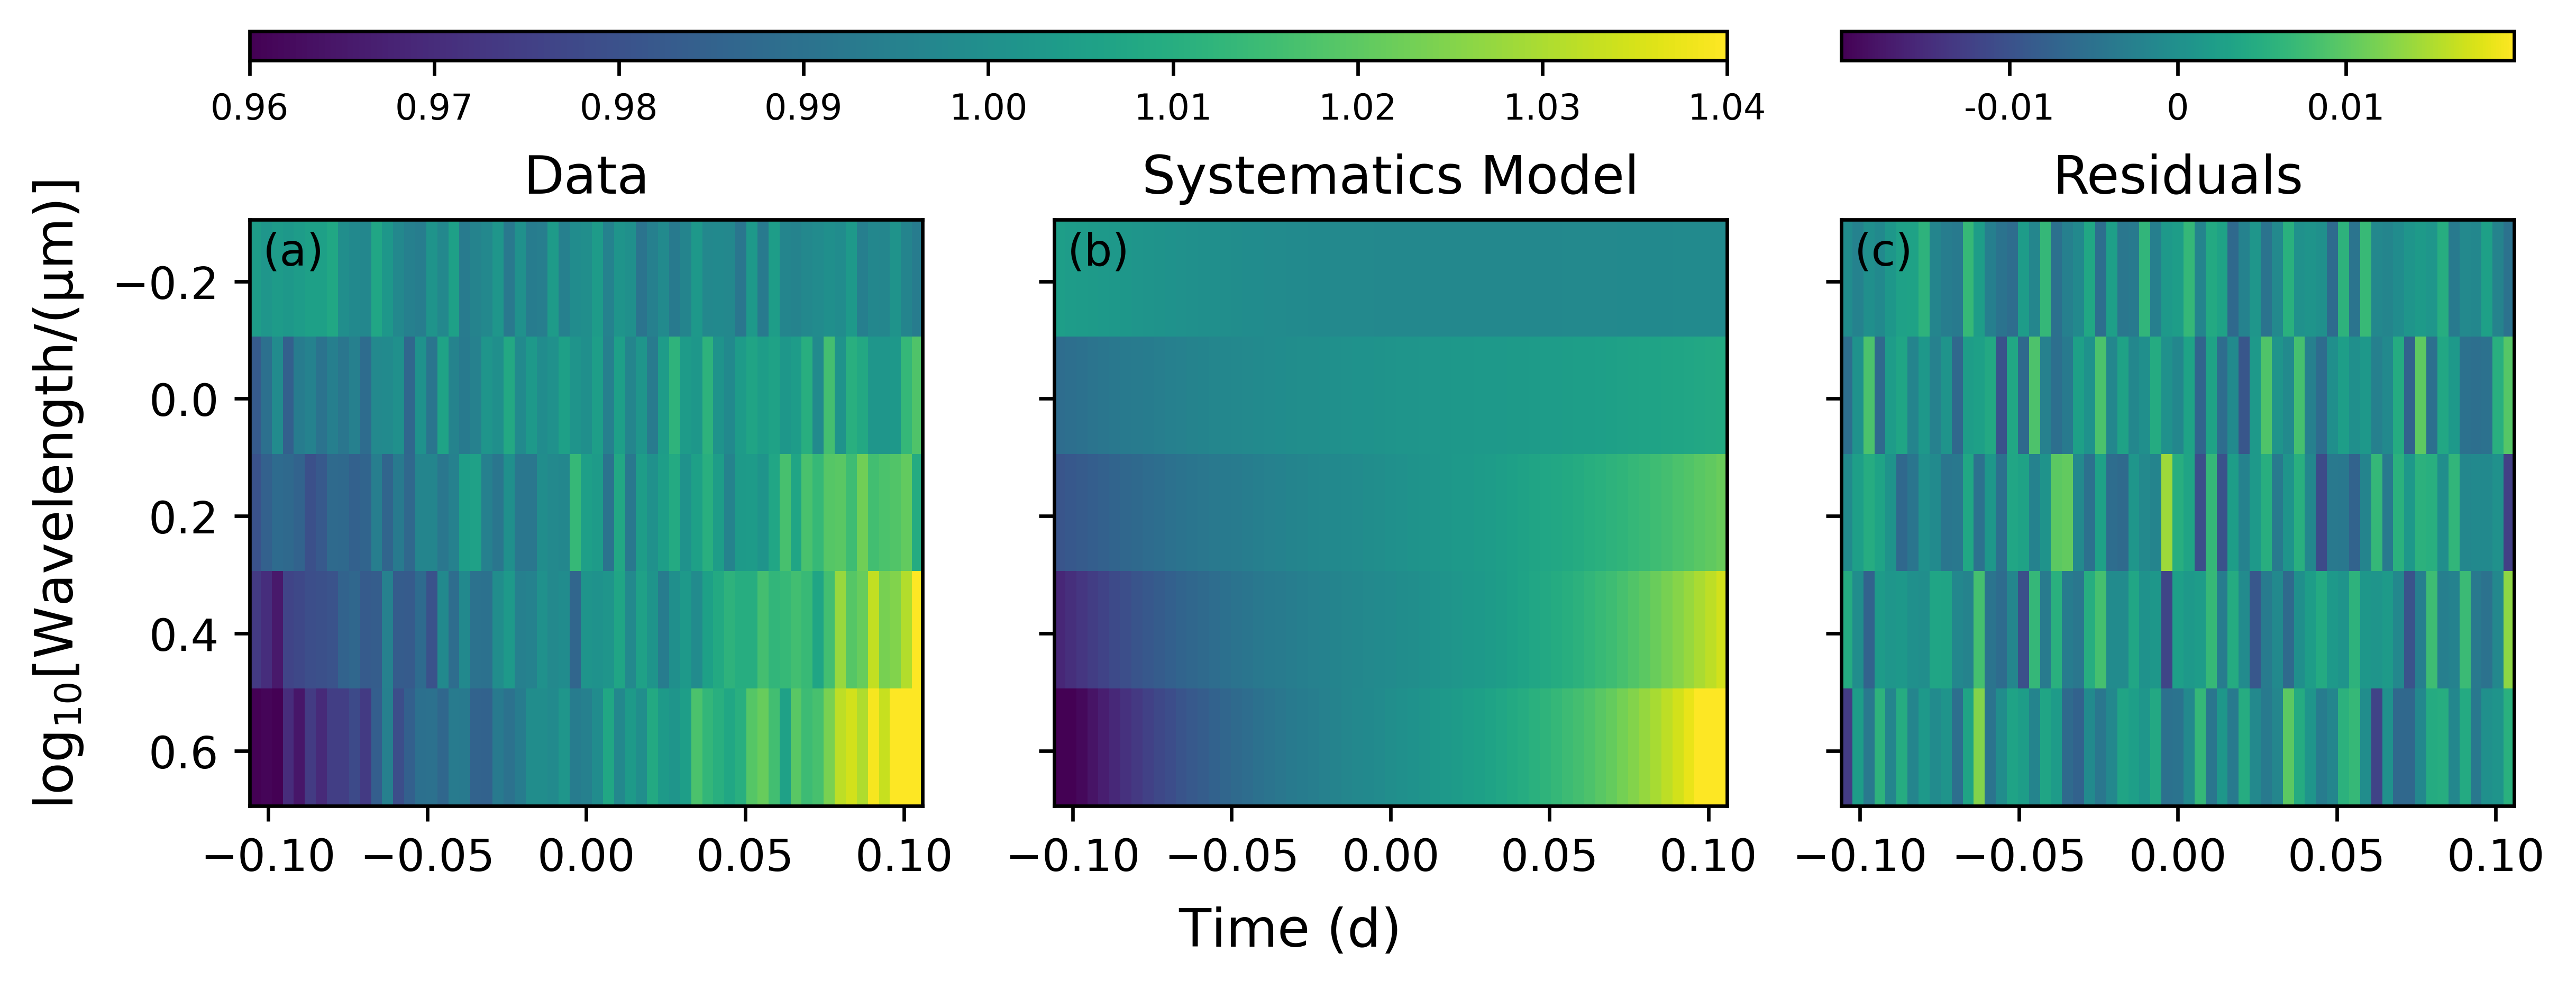

In [33]:
p.imshow_with_models(vlimits_data=[0.96, 1.04])


For Entire Simultaneous Fit:
Fitted Parameters:
 polynomial_p_0[0], polynomial_p_0[1], polynomial_p_0[2], polynomial_p_0[3], polynomial_p_0[4], polynomial_p_1[0], polynomial_p_1[1], polynomial_p_1[2], polynomial_p_1[3], polynomial_p_1[4], polynomial_p_2[0], polynomial_p_2[1], polynomial_p_2[2], polynomial_p_2[3], polynomial_p_2[4], polynomial_p_3[0], polynomial_p_3[1], polynomial_p_3[2], polynomial_p_3[3], polynomial_p_3[4]

Degrees of Freedom = n_waves (5) * n_times (61) - n_fitted_parameters (20) = 285
chi squared = 293.753811419832
Reduced chi squared = 1.0307151277888842
For 285 degrees of freedom, a model that 
    accurately describes the data could result in a 
    $\chi^2>$294 with a probability ($p$-value) of 0.348.
A model with a $p$-value of 0.348 is just as
        unlikely as drawing a value more than 0.391$\sigma$ above the 
        mean of a Gaussian distribution.


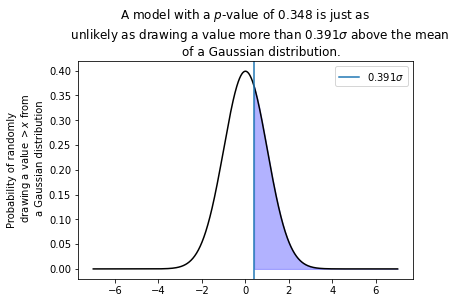

In [35]:
p.chi_squared(plot=True)

## Compare Results to the True Values

We can also compare our fitted results to the true values we put in:

In [42]:
results = p.get_results(uncertainty=['sd','sd'])
results

,polynomial_p_0,polynomial_p_0_sd,polynomial_p_1,polynomial_p_1_sd,polynomial_p_2,polynomial_p_2_sd,polynomial_p_3,polynomial_p_3_sd,wavelength
w0,0.997409,0.000922,-0.01525,0.018811,0.39035,0.189969,-1.435853,2.463538,0.639572482934883 micron
w1,1.00137,0.000899,0.061402,0.024351,-0.260727,0.184121,3.226987,3.40312,1.013209338074884 micron
w2,1.000047,0.0009,0.127504,0.024582,0.1259,0.185135,6.261776,3.471172,1.604998553797903 micron
w3,0.998647,0.000914,0.145623,0.024372,0.269948,0.185368,15.60011,3.438797,2.542436455025025 micron
w4,0.999434,0.000897,0.200483,0.018977,0.144662,0.18393,21.475241,2.429062,4.027407446906737 micron


In [43]:
print("\t\t\tTrue, \tFitted")
for w in range(p.data.nwave):
    for i, coeff in zip(range(p.degree+1),[true_a, true_b, true_c, true_d]):
        print(f"wavelength {w}, p_{i}:\t {round(coeff[w],2)}, \t",results.loc[f'w{w}'][f"{p.name}_p_{i}"],"+/-",results.loc[f'w{w}'][f"{p.name}_p_{i}_sd"])

			True, 	Fitted
wavelength 0, p_0:	 1.0, 	 0.9974089 +/- 0.0009224
wavelength 0, p_1:	 0.0, 	 -0.0152498 +/- 0.018811
wavelength 0, p_2:	 0.0, 	 0.3903504 +/- 0.1899685
wavelength 0, p_3:	 0.0, 	 -1.4358534 +/- 2.4635378
wavelength 1, p_0:	 1.0, 	 1.0013702 +/- 0.0008992
wavelength 1, p_1:	 0.05, 	 0.0614016 +/- 0.0243507
wavelength 1, p_2:	 0.0, 	 -0.2607267 +/- 0.1841207
wavelength 1, p_3:	 5.0, 	 3.2269871 +/- 3.4031204
wavelength 2, p_0:	 1.0, 	 1.0000465 +/- 0.0008997
wavelength 2, p_1:	 0.1, 	 0.127504 +/- 0.0245823
wavelength 2, p_2:	 0.0, 	 0.1259001 +/- 0.1851347
wavelength 2, p_3:	 10.0, 	 6.2617757 +/- 3.4711722
wavelength 3, p_0:	 1.0, 	 0.9986473 +/- 0.0009137
wavelength 3, p_1:	 0.15, 	 0.1456228 +/- 0.0243716
wavelength 3, p_2:	 0.0, 	 0.2699482 +/- 0.1853684
wavelength 3, p_3:	 15.0, 	 15.6001095 +/- 3.4387965
wavelength 4, p_0:	 1.0, 	 0.999434 +/- 0.0008974
wavelength 4, p_1:	 0.2, 	 0.2004828 +/- 0.0189773
wavelength 4, p_2:	 0.0, 	 0.1446622 +/- 0.1839305
wavelengt

Let's plot the data, the true regression line and our fit and see how they compare (If we used `store_model=True` at the `.setup_lightcurves()` stage then we could easily generate a 1-sigma region for the model using the errors stored in the summary table!):

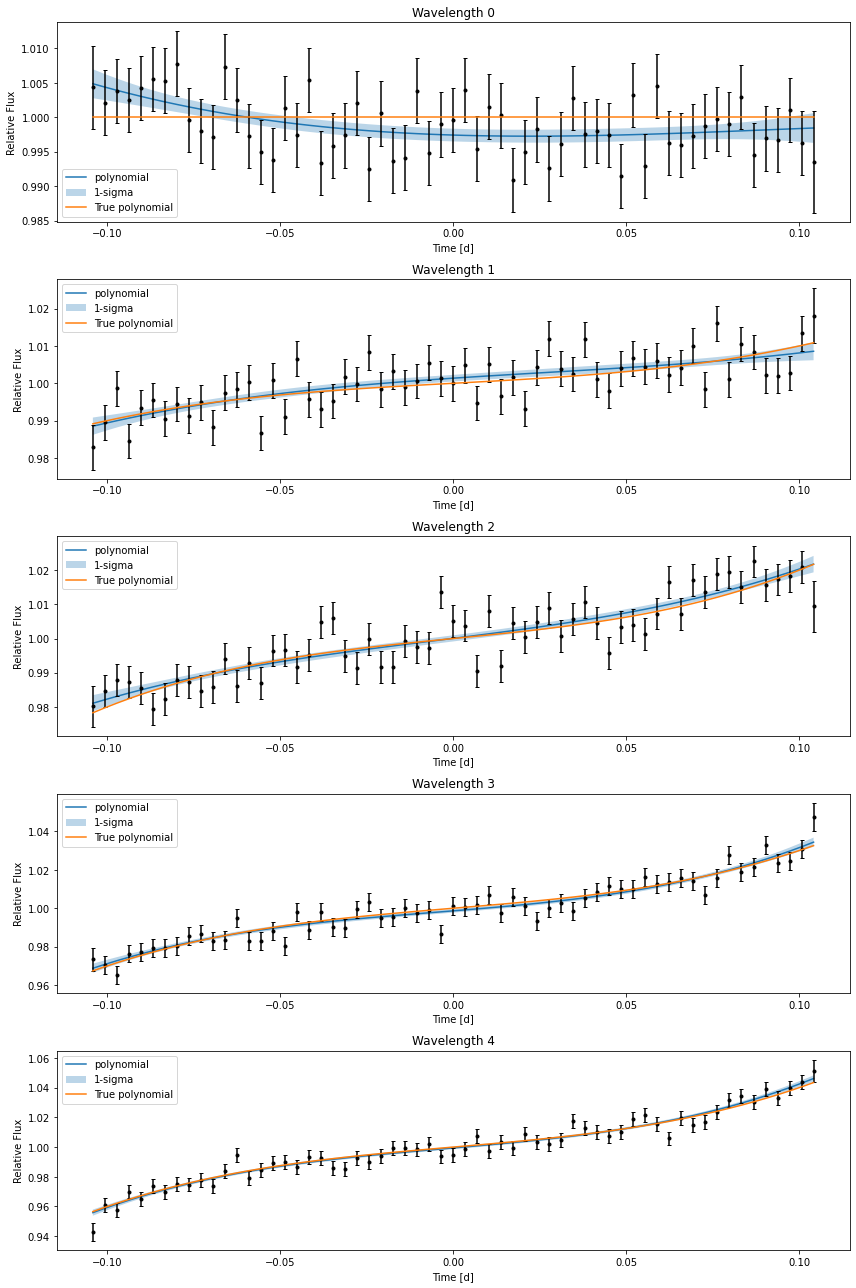

In [44]:
fig, ax = plt.subplots(p.data.nwave, figsize=(12,18))
p.plot_model(ax=ax)
plt.tight_layout();

# get 1-sigma region (only if store_models=True!!):
onesigma={}
for w in range(p.data.nwave):
    if f"w{w}" not in onesigma.keys():
        onesigma[f"w{w}"] = []
    for t in range(p.data.ntime):
        if p.optimization == "separate":
            onesigma[f"w{w}"].append(p.summary[w]["sd"][f"{p.name}_model[0, {t}]"])
        else:
            onesigma[f"w{w}"].append(p.summary["sd"][f"{p.name}_model[{w}, {t}]"])
        
        
for i in range(len(poly)):
    ax[i].fill_between(p.data.time.to_value("d"), np.array(model[f"w{i}"])-onesigma[f"w{i}"], np.array(model[f"w{i}"])+onesigma[f"w{i}"], label='1-sigma', alpha=0.3)
    ax[i].plot(p.data.time, p.data.model[i], label="True polynomial")
    ax[i].legend()

This is a good example to see where the model does a good job of fitting, and where, when the noise is larger than the signal, it can overfit (wavelength 0).

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


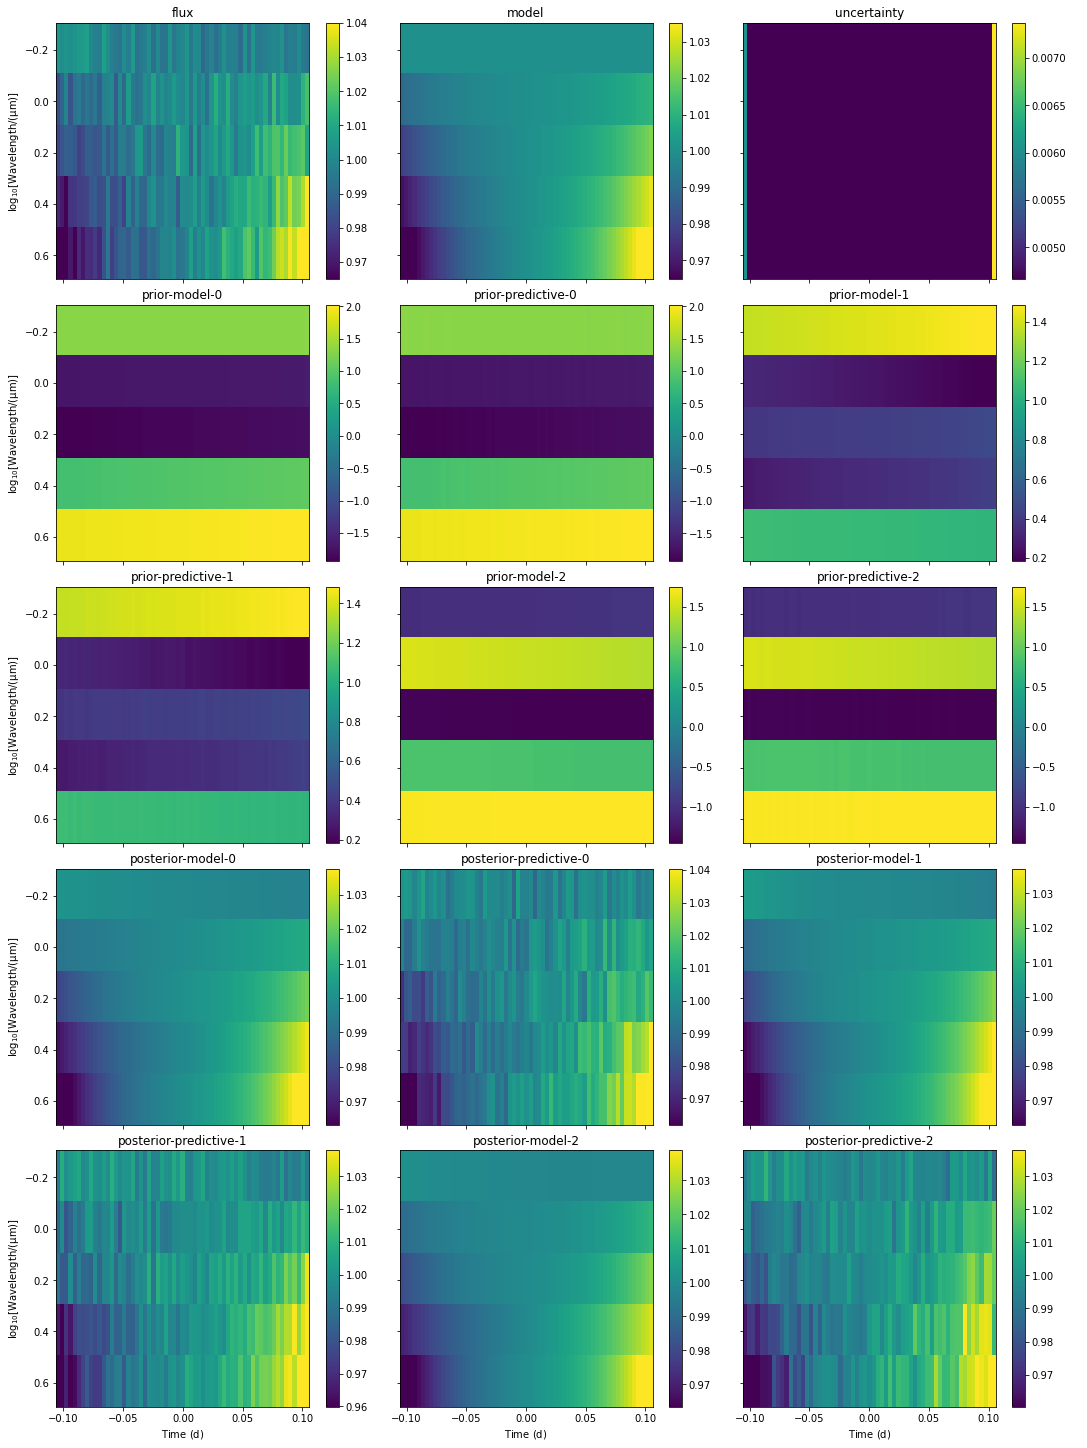

In [45]:
p.plot_posteriors()